In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=1, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=1, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)




In [5]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
    # Evaluate model predictions on a sample of test data
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

         # Separate correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:
            
            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))
            
            # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
                
            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

        elif len(incorrect_idxs) == 1:
            fig, axs = plt.subplots(2, 1, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                 global_step=num_epoch)
        else:
            
            # Create a figure with a single row of correct prediction plots
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            
            # Plot correct predictions in the single row
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
        # Save or show the figure
        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()
        
        


# Resnet 50 MNIST

In [12]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_ResNet50_results/'
    image_save_dir = './MNIST_ResNet50_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 30    
    
    #Load MNIST dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) ])

    train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = ResNet50().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
        """
            Initializes the weights of neural network layers using Xavier initialization.

           Args:
            - m: a layer of a neural network

          Returns:
           - None
        """            
           # Check if the layer is an instance of nn.Linear or nn.Conv2d
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                        
             # Apply Xavier initialization to the layer's weights
            torch.nn.init.xavier_normal_(m.weight) 
            
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
  
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)
                running_test_loss += test_loss.item() 
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_loss_epoch_array.append(test_loss.item())
        test_epoch_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 


        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))
        
        path = image_save_dir + '/MNIST_ResNet50_' + str(epoch + 1) + '.png'
        
        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)

         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()    
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        ]
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)

    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

100%|██████████| 469/469 [00:31<00:00, 15.12it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 30              | 72.55333333333333    | 17.91                | 1.0832152860378153   | 6.2417649800264385   | 34.14320516586304    |


100%|██████████| 469/469 [00:31<00:00, 14.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 30              | 72.86666666666666    | 80.63                | 1.271956843512653    | 3.3414769323566293   | 35.46490287780762    |


100%|██████████| 469/469 [00:30<00:00, 15.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 30              | 89.95                | 93.89                | 0.45272114863400775  | 0.2920479978187175   | 33.62356948852539    |


100%|██████████| 469/469 [00:31<00:00, 14.87it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 30              | 94.38666666666667    | 95.53                | 0.1788212045479113   | 0.2880389233697442   | 34.58982563018799    |


100%|██████████| 469/469 [00:31<00:00, 15.13it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 30              | 96.05666666666667    | 96.64                | 0.12563060709773732  | 0.1878416159579271   | 34.04449677467346    |


100%|██████████| 469/469 [00:30<00:00, 15.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 30              | 96.71                | 96.93                | 0.10293733576602583  | 0.18997393068091212  | 34.05828380584717    |


100%|██████████| 469/469 [00:31<00:00, 15.09it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 30              | 97.28333333333333    | 97.54                | 0.08471475074738899  | 0.15018992715285312  | 34.097511529922485   |


100%|██████████| 469/469 [00:31<00:00, 14.89it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 30              | 97.53333333333333    | 97.73                | 0.0754443234476104   | 0.19052498771137075  | 34.66748595237732    |


100%|██████████| 469/469 [00:31<00:00, 14.93it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 30              | 97.88666666666667    | 97.82                | 0.06556896364260743  | 0.2994294104614307   | 34.43271994590759    |


100%|██████████| 469/469 [00:30<00:00, 15.35it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 30             | 98.11333333333333    | 97.48                | 0.05837466644851971  | 0.3191770814989894   | 33.62886095046997    |


100%|██████████| 469/469 [00:31<00:00, 14.97it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 30             | 98.29666666666667    | 98.4                 | 0.0544871825859872   | 0.059510848548298675 | 34.275213956832886   |


100%|██████████| 469/469 [00:30<00:00, 15.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 30             | 98.385               | 98.6                 | 0.05170923823873991  | 0.05017520475151206  | 34.07934856414795    |


100%|██████████| 469/469 [00:31<00:00, 14.97it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 30             | 98.49166666666666    | 98.28                | 0.04783974083682606  | 0.07316283371499917  | 34.54632616043091    |


100%|██████████| 469/469 [00:31<00:00, 15.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 30             | 98.46166666666667    | 98.68                | 0.04742168367846307  | 0.040498520120170814 | 34.199265003204346   |


100%|██████████| 469/469 [00:31<00:00, 15.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 30             | 98.74833333333333    | 98.59                | 0.03983294176779735  | 0.04231805850558655  | 34.11452913284302    |


100%|██████████| 469/469 [00:31<00:00, 14.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 30             | 98.665               | 98.75                | 0.040871321725577656 | 0.04049617878848074  | 34.729987382888794   |


100%|██████████| 469/469 [00:31<00:00, 14.84it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 30             | 98.79166666666667    | 98.39                | 0.038563773680383016 | 0.04959206619370682  | 34.698752641677856   |


100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 30             | 98.74666666666667    | 98.78                | 0.03828734341315798  | 0.04140967862530246  | 34.50925540924072    |


100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 30             | 98.83333333333333    | 98.74                | 0.03466781078111023  | 0.04422775827752739  | 34.42346167564392    |


100%|██████████| 469/469 [00:30<00:00, 15.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 30             | 98.88333333333334    | 98.62                | 0.0344291437168552   | 0.046932518676724995 | 34.12665343284607    |


100%|██████████| 469/469 [00:32<00:00, 14.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 30             | 98.88333333333334    | 98.97                | 0.03331079755945485  | 0.0333312859878834   | 35.10651206970215    |


100%|██████████| 469/469 [00:31<00:00, 15.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 30             | 99.02333333333333    | 98.95                | 0.03191597301732384  | 0.03162670495925041  | 34.13908267021179    |


100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 30             | 99.07833333333333    | 98.89                | 0.02883526973792715  | 0.03888048362200549  | 34.56222152709961    |


100%|██████████| 469/469 [00:30<00:00, 15.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 30             | 98.95333333333333    | 98.76                | 0.031125748048234644 | 0.032584570092959564 | 33.48687791824341    |


100%|██████████| 469/469 [00:31<00:00, 15.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 30             | 99.09666666666666    | 98.85                | 0.028245296843075897 | 0.036068356311342184 | 34.36257576942444    |


100%|██████████| 469/469 [00:30<00:00, 15.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 30             | 99.06666666666666    | 98.93                | 0.028568015740027645 | 0.03161617982808406  | 33.984683990478516   |


100%|██████████| 469/469 [00:31<00:00, 14.85it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 30             | 99.15                | 98.94                | 0.026547324357192908 | 0.033367686619086165 | 34.6535267829895     |


100%|██████████| 469/469 [00:31<00:00, 14.84it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 30             | 99.13666666666667    | 99.18                | 0.025478526241461765 | 0.02610298049565452  | 34.59951829910278    |


100%|██████████| 469/469 [00:30<00:00, 15.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 30             | 99.06833333333333    | 98.86                | 0.026663801217921324 | 0.0344859635239302   | 34.5422728061676     |


100%|██████████| 469/469 [00:30<00:00, 15.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 30             | 99.13833333333334    | 99.02                | 0.02685113445714688  | 0.0320336580091551   | 33.90801644325256    |


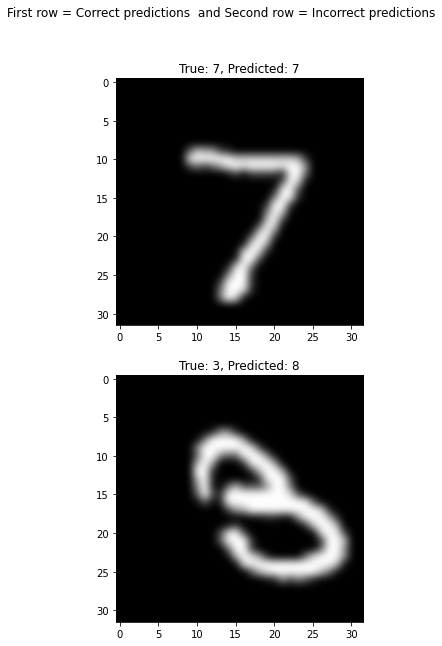

In [21]:
show_loss(Losses, save=True, path=save_dir + '/MNIST_Resnet50_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/MNIST_Resnet50_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)

# Resnet50 Cifar

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)



In [11]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
   
    classes = test_data.classes
    with torch.no_grad():            
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Plot correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:

            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))

             # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[0, i].imshow(img,interpolation='bicubic')
                axs[0, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img,dataformats='HWC', 
                                  global_step=num_epoch)

            # Plot incorrect predictions
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[1, i].imshow(img,interpolation='bicubic')
                axs[1, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)
        else:
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[i].imshow(img,interpolation='bicubic')
                axs[i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)

        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()


In [14]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './CIFAR10_data/'
    save_dir = './CIFAR10_results/'
    image_save_dir = './CIFAR10_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 100    
    
    #Load MNIST dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]) ])

    train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = ResNet50().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
        """
            Initializes the weights of neural network layers using Xavier initialization.

           Args:
            - m: a layer of a neural network

          Returns:
           - None
        """            
           # Check if the layer is an instance of nn.Linear or nn.Conv2d
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                        
             # Apply Xavier initialization to the layer's weights
            torch.nn.init.xavier_normal_(m.weight) 
            
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
  
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)
                running_test_loss += test_loss.item() 
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_loss_epoch_array.append(test_loss.item())
        test_epoch_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 


        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))
        
        path = image_save_dir + '/CIFAR_ResNet50_' + str(epoch + 1) + '.png'
        
        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)

         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()    
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        ]
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)


    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

Files already downloaded and verified


100%|██████████| 391/391 [00:33<00:00, 11.81it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 100             | 22.248               | 31.72                | 2.8428446722152594   | 2.2650052641011493   | 37.05610799789429    |


100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 100             | 29.996               | 29.13                | 2.267228361285861    | 2.102631229388563    | 38.16686129570007    |


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 100             | 32.422               | 38.1                 | 2.05240451374932     | 2.0666187216963947   | 38.707895040512085   |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 100             | 38.072               | 39.62                | 1.874271035194397    | 2.0879976402355145   | 37.72589039802551    |


100%|██████████| 391/391 [00:33<00:00, 11.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 100             | 40.396               | 42.39                | 1.7797349380410237   | 1.7052476541905464   | 37.370323181152344   |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 100             | 43.13                | 42.32                | 1.6809655705376354   | 2.7482186057899574   | 37.7424635887146     |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 100             | 42.892               | 44.87                | 1.685984456935502    | 1.8253029237819622   | 37.48089408874512    |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 100             | 44.022               | 43.47                | 1.6414839190900172   | 2.2391360862345637   | 37.38127064704895    |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 100             | 46.642               | 48.57                | 1.5608447363309543   | 1.906772628615174    | 37.55923652648926    |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 100            | 47.998               | 49.3                 | 1.522999980870415    | 1.9120739954936354   | 37.68321990966797    |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 100            | 49.556               | 45.5                 | 1.4661388946006366   | 1.9933542269694655   | 37.72565245628357    |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 100            | 49.018               | 40.82                | 1.462878952245883    | 2.4125648510606985   | 37.71258807182312    |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 100            | 45.598               | 48.79                | 1.5497857326131952   | 2.0230783314644536   | 37.62293028831482    |


100%|██████████| 391/391 [00:33<00:00, 11.81it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 100            | 50.098               | 48.18                | 1.432885915726957    | 1.570655137677736    | 37.23279786109924    |


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 100            | 50.01                | 51.94                | 1.4209880892882871   | 1.4887654358827616   | 38.51117658615112    |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 100            | 52.682               | 53.18                | 1.3612075992252515   | 3.1053919973252695   | 37.666868686676025   |


100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 100            | 54.642               | 54.62                | 1.2973255242228203   | 1.5500485444370704   | 37.70949029922485    |


100%|██████████| 391/391 [00:33<00:00, 11.70it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 100            | 53.43                | 55.1                 | 1.3373488225900303   | 1.3753201041040541   | 37.33538317680359    |


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 100            | 56.244               | 54.72                | 1.2554574354225412   | 5.332309998288939    | 37.20640206336975    |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 100            | 57.212               | 57.28                | 1.2171016033653104   | 2.1467505534992943   | 37.603901624679565   |


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 100            | 59.148               | 58.88                | 1.1715729599413665   | 1.8725663717788985   | 37.54804849624634    |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 100            | 60.686               | 60.16                | 1.1297049264773689   | 1.780789631831495    | 37.51301026344299    |


100%|██████████| 391/391 [00:32<00:00, 12.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 100            | 61.762               | 59.75                | 1.0935829275709283   | 1.6643154968189289   | 36.413209438323975   |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 100            | 62.846               | 61.86                | 1.0664875513452399   | 2.9786883087097844   | 37.571364641189575   |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 100            | 63.864               | 62.4                 | 1.0370586429105695   | 1.3688617763640005   | 37.66945838928223    |


100%|██████████| 391/391 [00:32<00:00, 11.90it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 100            | 64.734               | 61.45                | 1.010361805901198    | 1.6339635147324092   | 36.86892342567444    |


100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 100            | 65.696               | 63.85                | 0.9816345868208219   | 1.4715739880936056   | 36.07294940948486    |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 100            | 66.606               | 63.95                | 0.9552616585246132   | 4.474321033381209    | 37.43824028968811    |


100%|██████████| 391/391 [00:33<00:00, 11.79it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 100            | 67.156               | 64.45                | 0.9420066364585896   | 1.443076893498626    | 37.284441232681274   |


100%|██████████| 391/391 [00:33<00:00, 11.61it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 100            | 68.12                | 64.86                | 0.9113331402049345   | 1.6979376613339292   | 37.51952075958252    |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 31 of 100            | 68.806               | 65.79                | 0.8929584695555061   | 1.3984813539287713   | 37.44430708885193    |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 32 of 100            | 69.738               | 65.99                | 0.8636663963117868   | 1.2981035467944568   | 37.5440731048584     |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 33 of 100            | 70.624               | 66.66                | 0.8440850733796044   | 1.4018179887457738   | 37.58216857910156    |


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 34 of 100            | 71.044               | 67.11                | 0.826130110132115    | 1.8382439643521853   | 37.38939642906189    |


100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 35 of 100            | 71.886               | 67.83                | 0.8021802560752614   | 2.1098779892619652   | 37.43925976753235    |


100%|██████████| 391/391 [00:33<00:00, 11.79it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 36 of 100            | 72.326               | 66.8                 | 0.7914771184591991   | 1.2641869436336468   | 37.10346484184265    |


100%|██████████| 391/391 [00:33<00:00, 11.83it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 37 of 100            | 73.148               | 67.36                | 0.7644772396977905   | 1.0547882937177826   | 36.98600673675537    |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 38 of 100            | 73.734               | 68.51                | 0.7527579355727682   | 1.0254612383963186   | 37.56291651725769    |


100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 39 of 100            | 74.252               | 70.21                | 0.7340059996870778   | 1.062882172910473    | 38.095391273498535   |


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 40 of 100            | 74.82                | 71.02                | 0.7237625361403541   | 1.1958623868000657   | 37.09434533119202    |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 41 of 100            | 75.414               | 70.17                | 0.7011524758223072   | 1.6798511139954193   | 37.820937395095825   |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 42 of 100            | 75.566               | 71.26                | 0.6970795167376623   | 1.0225865418397928   | 37.552000999450684   |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 43 of 100            | 76.402               | 69.14                | 0.6701346494810051   | 1.8573089204257047   | 37.50933623313904    |


100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 44 of 100            | 76.718               | 70.49                | 0.6600239475822205   | 1.0371701302407663   | 37.501131772994995   |


100%|██████████| 391/391 [00:32<00:00, 11.91it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 45 of 100            | 77.418               | 72.0                 | 0.6394340498825474   | 1.206471111201033    | 36.81917357444763    |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 46 of 100            | 78.05                | 72.48                | 0.6263993367971972   | 0.9748021447205846   | 37.401485443115234   |


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 47 of 100            | 77.938               | 71.64                | 0.6273927687074218   | 0.9970813559580453   | 37.3006055355072     |


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 48 of 100            | 78.864               | 72.41                | 0.6029782818863764   | 1.1230086978477767   | 37.188878774642944   |


100%|██████████| 391/391 [00:33<00:00, 11.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 49 of 100            | 79.292               | 72.95                | 0.5870950914100003   | 0.9860122980950754   | 37.41593551635742    |


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 50 of 100            | 79.316               | 72.69                | 0.5846904903421621   | 1.3255976928940303   | 37.39058589935303    |


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 51 of 100            | 79.848               | 71.64                | 0.5698947995672445   | 1.008357809314245    | 37.178481101989746   |


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 52 of 100            | 80.048               | 72.88                | 0.5648598962122827   | 0.841937204705009    | 37.477224349975586   |


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 53 of 100            | 80.458               | 72.54                | 0.5546426005528101   | 0.9423300646528413   | 36.71674203872681    |


100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 54 of 100            | 81.052               | 72.03                | 0.5366780483509268   | 1.1103816349295121   | 37.87330222129822    |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 55 of 100            | 81.402               | 73.25                | 0.5268599397081244   | 0.9335807780676251   | 37.23954200744629    |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 56 of 100            | 81.718               | 73.47                | 0.515205803124801    | 1.9503255456308775   | 37.22760462760925    |


100%|██████████| 391/391 [00:32<00:00, 11.87it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 57 of 100            | 81.37                | 71.72                | 0.5308535287294851   | 1.7166454844836947   | 36.867634773254395   |


100%|██████████| 391/391 [00:32<00:00, 11.86it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 58 of 100            | 82.238               | 73.8                 | 0.5060045809087241   | 0.897520029846626    | 36.952643632888794   |


100%|██████████| 391/391 [00:33<00:00, 11.60it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 59 of 100            | 82.88                | 74.11                | 0.4840478641374032   | 1.1827157633968546   | 37.65798878669739    |


100%|██████████| 391/391 [00:32<00:00, 11.87it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 60 of 100            | 80.248               | 72.9                 | 0.5580049971942707   | 1.0798847034007688   | 36.87423086166382    |


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 61 of 100            | 81.892               | 73.06                | 0.5149720633578727   | 1.0272148168539699   | 37.11492133140564    |


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 62 of 100            | 82.762               | 70.14                | 0.48967875643154546  | 1.9297212347199646   | 37.547159910202026   |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 63 of 100            | 82.622               | 74.01                | 0.4921815569138588   | 0.9498589280285413   | 37.323636293411255   |


100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 64 of 100            | 81.718               | 66.84                | 0.5187935211012126   | 1.0853205813637263   | 36.054762840270996   |


100%|██████████| 391/391 [00:33<00:00, 11.77it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 65 of 100            | 83.338               | 75.63                | 0.4729492824400782   | 0.7763980819454676   | 37.12490391731262    |


100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 66 of 100            | 84.138               | 72.55                | 0.44669476471593617  | 0.927452651005757    | 37.03255486488342    |


100%|██████████| 391/391 [00:32<00:00, 12.04it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 67 of 100            | 84.662               | 74.79                | 0.43559646255829754  | 0.7945125710360611   | 36.50658130645752    |


100%|██████████| 391/391 [00:33<00:00, 11.76it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 68 of 100            | 85.136               | 75.05                | 0.4208729786183828   | 0.8553630362583112   | 37.193952560424805   |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 69 of 100            | 85.294               | 72.88                | 0.4189551133481438   | 0.8520918473412719   | 37.438334465026855   |


100%|██████████| 391/391 [00:33<00:00, 11.70it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 70 of 100            | 85.37                | 74.95                | 0.41355974747396795  | 0.7898494729512855   | 37.42416048049927    |


100%|██████████| 391/391 [00:33<00:00, 11.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 71 of 100            | 85.776               | 75.77                | 0.4018387985427666   | 0.8159847614131396   | 36.36272048950195    |


100%|██████████| 391/391 [00:33<00:00, 11.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 72 of 100            | 86.42                | 75.17                | 0.38490922078299705  | 0.7811456254765957   | 37.088329792022705   |


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 73 of 100            | 85.854               | 75.7                 | 0.400519261846457    | 0.7962050045592876   | 37.25390553474426    |


100%|██████████| 391/391 [00:32<00:00, 11.89it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 74 of 100            | 86.636               | 75.2                 | 0.37867119363354296  | 0.7892725980734523   | 36.7287917137146     |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 75 of 100            | 86.848               | 75.16                | 0.3732356267893101   | 0.8174699239338501   | 37.330851316452026   |


100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 76 of 100            | 87.096               | 75.57                | 0.36472589231055713  | 0.7984524474868292   | 37.348214626312256   |


100%|██████████| 391/391 [00:33<00:00, 11.79it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 77 of 100            | 85.882               | 75.01                | 0.3973023185644613   | 0.7749842420408998   | 37.03635263442993    |


100%|██████████| 391/391 [00:33<00:00, 11.66it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 78 of 100            | 87.082               | 74.41                | 0.36342271598403714  | 0.831770247296442    | 37.402135610580444   |


100%|██████████| 391/391 [00:33<00:00, 11.56it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 79 of 100            | 87.194               | 75.99                | 0.3561162861716717   | 0.7559883579423156   | 37.771841287612915   |


100%|██████████| 391/391 [00:33<00:00, 11.69it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 80 of 100            | 87.908               | 76.08                | 0.3427487451325902   | 0.7537142453314383   | 37.5150101184845     |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 81 of 100            | 88.194               | 69.44                | 0.3373261250727012   | 1.1627199959151353   | 37.210031509399414   |


100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 82 of 100            | 87.98                | 76.15                | 0.33740103724972365  | 0.77691687398319     | 37.23763084411621    |


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 83 of 100            | 88.484               | 76.55                | 0.3256634516865396   | 0.7504315380054184   | 37.60669803619385    |


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 84 of 100            | 88.444               | 75.33                | 0.32301264402963925  | 0.7741830873338482   | 37.87578868865967    |


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 85 of 100            | 88.676               | 75.25                | 0.3192589337487355   | 0.819626462610462    | 37.3292875289917     |


100%|██████████| 391/391 [00:32<00:00, 11.94it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 86 of 100            | 88.746               | 76.33                | 0.31758213664412194  | 0.7728056734121298   | 36.703558921813965   |


100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 87 of 100            | 88.888               | 74.79                | 0.31350770268751227  | 0.8457035580767861   | 38.03812575340271    |


100%|██████████| 391/391 [00:33<00:00, 11.81it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 88 of 100            | 88.9                 | 76.15                | 0.30724737166291305  | 0.7794520190999478   | 37.018341064453125   |


100%|██████████| 391/391 [00:32<00:00, 11.85it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 89 of 100            | 89.222               | 76.93                | 0.3057916551980826   | 0.7513336667531654   | 36.83254027366638    |


100%|██████████| 391/391 [00:33<00:00, 11.83it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 90 of 100            | 89.098               | 76.27                | 0.30700767791027306  | 0.7868502256990988   | 36.926382541656494   |


100%|██████████| 391/391 [00:33<00:00, 11.84it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 91 of 100            | 89.174               | 77.34                | 0.3005918691415921   | 0.7454004355623752   | 37.03383135795593    |


100%|██████████| 391/391 [00:31<00:00, 12.27it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 92 of 100            | 89.69                | 78.01                | 0.29321461382424435  | 0.7371788937834245   | 35.993311643600464   |


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 93 of 100            | 89.728               | 76.47                | 0.2870107261497346   | 0.7789377849313277   | 37.10706543922424    |


100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 94 of 100            | 89.598               | 76.96                | 0.2942049223215074   | 0.775779327259788    | 36.316314458847046   |


100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 95 of 100            | 89.76                | 74.89                | 0.2912419048111762   | 0.8549273496941675   | 37.40026497840881    |


100%|██████████| 391/391 [00:32<00:00, 11.98it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 96 of 100            | 89.974               | 76.93                | 0.2856102799591811   | 0.7437144834784013   | 36.690102100372314   |


100%|██████████| 391/391 [00:33<00:00, 11.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 97 of 100            | 89.904               | 76.33                | 0.28832552797349215  | 0.8037712785262096   | 37.5418062210083     |


100%|██████████| 391/391 [00:33<00:00, 11.70it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 98 of 100            | 90.224               | 77.16                | 0.277009160774748    | 0.7724760001218771   | 37.329219579696655   |


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 99 of 100            | 90.514               | 75.63                | 0.27040091271290695  | 0.8153574391256405   | 37.24215745925903    |


100%|██████████| 391/391 [00:33<00:00, 11.77it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 100 of 100           | 90.36                | 76.91                | 0.2743149543433543   | 0.7766735674459723   | 37.23606848716736    |


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

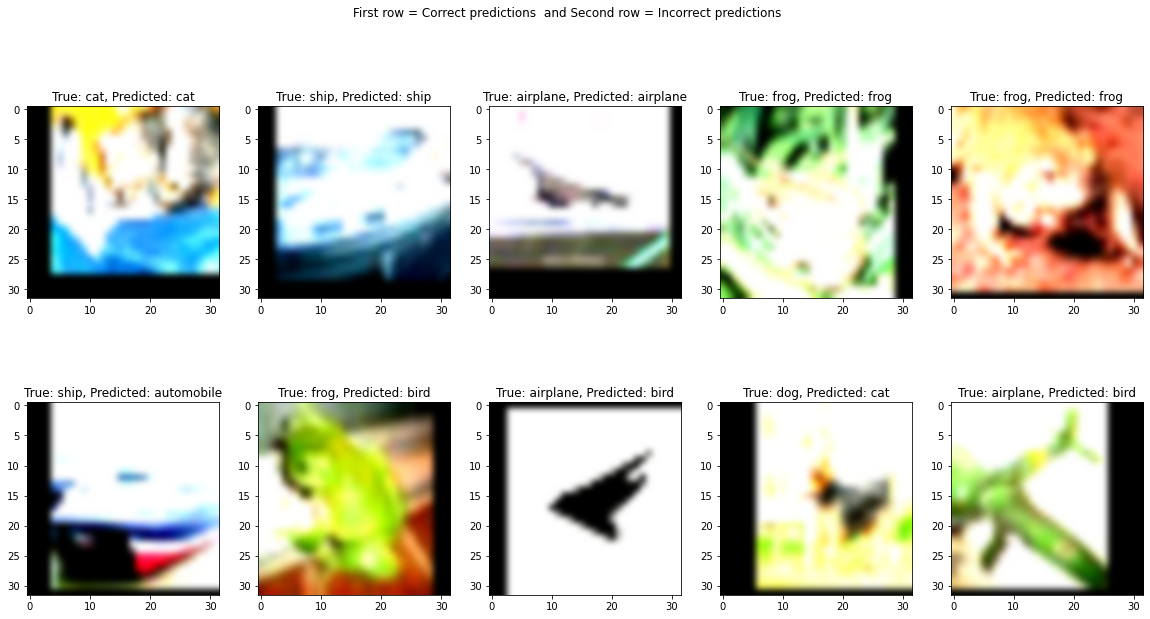

In [15]:
show_loss(Losses, save=True, path=save_dir + '/CIFAR_Resnet50_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/CIFAR_Resnet50_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)

# RESNET101 ON MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=1, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=1, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=1, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)





In [2]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
    # Evaluate model predictions on a sample of test data
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        
        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

         # Separate correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:
            
            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))
            
            # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
                
            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1, i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1, i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

        elif len(incorrect_idxs) == 1:
            fig, axs = plt.subplots(2, 1, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions  in the first row
            for i, idx in enumerate(correct_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[0].imshow(img, cmap="gray",interpolation='bicubic')
                axs[0].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)

            # Plot incorrect predictions in the second row
            for i, idx in enumerate(incorrect_idxs[:1]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[1].imshow(img, cmap="gray",interpolation='bicubic')
                axs[1].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                 global_step=num_epoch)
        else:
            
            # Create a figure with a single row of correct prediction plots
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            
            # Plot correct predictions in the single row
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx][0]
                label = labels.cpu()[idx]
                axs[i].imshow(img, cmap="gray",interpolation='bicubic')
                axs[i].set_title(f"True: {label.item()}, Predicted: {predicted[idx].item()}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HW', 
                                  global_step=num_epoch)
        # Save or show the figure
        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()
        
        


In [3]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_ResNet101_results/'
    image_save_dir = './MNIST_ResNet101_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 30    
    
    #Load MNIST dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) ])

    train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = ResNet101().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 6,factor =0.1)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
        """
            Initializes the weights of neural network layers using Xavier initialization.

           Args:
            - m: a layer of a neural network

          Returns:
           - None
        """            
           # Check if the layer is an instance of nn.Linear or nn.Conv2d
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                        
             # Apply Xavier initialization to the layer's weights
            torch.nn.init.xavier_normal_(m.weight) 
            
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
  
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)
                running_test_loss += test_loss.item() 
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_loss_epoch_array.append(test_loss.item())
        test_epoch_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 


        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))
        
        path = image_save_dir + '/MNIST_ResNet101_' + str(epoch + 1) + '.png'
        
        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)
        scheduler.step(train_loss)

         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()   
        
        temp  = scheduler.state_dict()
        Lr = temp['_last_lr'][0]
        
        # table_data = [
        # ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        # [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        # ]
        # # Define colors for each column
        # colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m']
        
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed','Learning Rate'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime,f'{ Lr:.8f}']
        ]
        
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m','\033[37m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)

    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

100%|██████████| 469/469 [01:01<00:00,  7.61it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 30              | 52.998333333333335   | 85.47                | 1.4875016535904362   | 0.6587264743409579   | 66.77869462966919    | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 30              | 92.24166666666666    | 96.01                | 0.2575858718455473   | 0.12401588782196558  | 61.409945011138916   | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.26it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 30              | 95.78833333333333    | 96.0                 | 0.13521851441546925  | 0.11857854956878891  | 61.418519496917725   | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 30              | 96.87666666666667    | 97.53                | 0.10232903787703403  | 0.08470155635872219  | 62.17300486564636    | 0.01000000           |


100%|██████████| 469/469 [00:58<00:00,  8.06it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 30              | 97.20166666666667    | 95.52                | 0.09022905307609452  | 0.13492093928441218  | 62.61438703536987    | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 30              | 97.515               | 97.35                | 0.08026619892972492  | 0.07640402290757888  | 60.46314454078674    | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.34it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 30              | 97.88                | 97.99                | 0.0690369014658018   | 0.05841180262792431  | 60.42050909996033    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 30              | 98.11166666666666    | 98.33                | 0.061596033083938205 | 0.048902174550008407 | 61.71152091026306    | 0.01000000           |


100%|██████████| 469/469 [00:55<00:00,  8.49it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 30              | 98.17333333333333    | 97.82                | 0.05756296328445678  | 0.06886092002232429  | 59.43157958984375    | 0.01000000           |


100%|██████████| 469/469 [00:54<00:00,  8.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 30             | 98.23                | 98.19                | 0.05576560330956475  | 0.05448542757525663  | 58.406055212020874   | 0.01000000           |


100%|██████████| 469/469 [00:54<00:00,  8.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 30             | 98.36166666666666    | 98.23                | 0.05262576974233362  | 0.05204200781469198  | 58.90973424911499    | 0.01000000           |


100%|██████████| 469/469 [00:55<00:00,  8.47it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 30             | 98.41666666666667    | 97.3                 | 0.04891368291868981  | 0.08784330381622797  | 59.66498851776123    | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 30             | 98.56333333333333    | 98.37                | 0.04687115754872592  | 0.05493784696895252  | 60.65063142776489    | 0.01000000           |


100%|██████████| 469/469 [00:56<00:00,  8.37it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 30             | 98.62                | 98.44                | 0.043532601362570866 | 0.04418180869962973  | 60.49282765388489    | 0.01000000           |


100%|██████████| 469/469 [00:58<00:00,  7.96it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 30             | 98.71                | 98.79                | 0.041257787512730494 | 0.03924855788656852  | 63.8050434589386     | 0.01000000           |


100%|██████████| 469/469 [00:58<00:00,  7.97it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 30             | 98.75                | 98.2                 | 0.041080305195435374 | 0.05614810177903104  | 62.8881938457489     | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 30             | 98.725               | 98.49                | 0.04118095733064499  | 0.04660115809595401  | 61.35553598403931    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 30             | 98.72666666666667    | 98.25                | 0.0396091056772188   | 0.055527854032219166 | 61.877636432647705   | 0.01000000           |


100%|██████████| 469/469 [00:58<00:00,  8.02it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 30             | 98.675               | 98.98                | 0.040767640789855585 | 0.03536838965484566  | 62.89208674430847    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 30             | 98.83333333333333    | 98.82                | 0.037857680383430264 | 0.037266139148092015 | 61.76376938819885    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.22it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 30             | 98.81666666666666    | 98.42                | 0.03606377441539312  | 0.05035923184205106  | 61.48120093345642    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 30             | 98.81833333333333    | 98.48                | 0.03671746823225798  | 0.04444674793719255  | 61.52773141860962    | 0.01000000           |


100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 23 of 30             | 98.855               | 98.79                | 0.034721327399505356 | 0.03939864725829397  | 61.584128856658936   | 0.01000000           |


100%|██████████| 469/469 [00:58<00:00,  8.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 24 of 30             | 98.925               | 98.71                | 0.03349691695088882  | 0.03895718746308732  | 62.57775807380676    | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 25 of 30             | 99.23833333333333    | 99.16                | 0.022666772377606767 | 0.022765533730411267 | 61.863120794296265   | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.11it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 26 of 30             | 99.37666666666667    | 99.19                | 0.01969250924411172  | 0.02334442709998487  | 62.09219002723694    | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 27 of 30             | 99.43666666666667    | 99.2                 | 0.018320099764398294 | 0.022685986331165208 | 61.9555389881134     | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 28 of 30             | 99.43333333333334    | 99.27                | 0.019015509560743948 | 0.02099418448438261  | 62.124452114105225   | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 29 of 30             | 99.41666666666667    | 99.2                 | 0.021215490804715104 | 0.025594486185950758 | 61.62777352333069    | 0.00100000           |


100%|██████████| 469/469 [00:57<00:00,  8.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 30 of 30             | 99.45666666666666    | 99.35                | 0.01700040666266843  | 0.018605198787784653 | 61.62536334991455    | 0.00100000           |


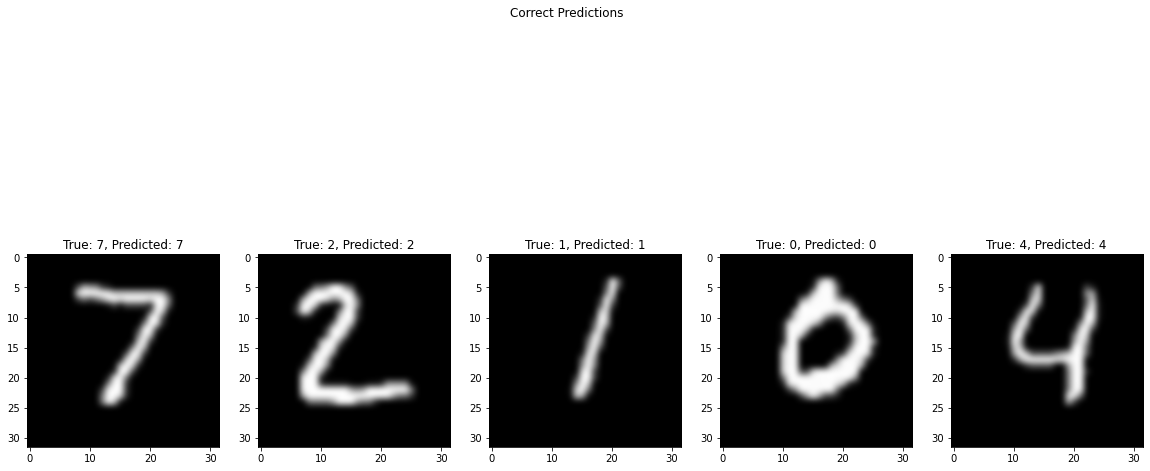

In [4]:
show_loss(Losses, save=True, path=save_dir + '/MNIST_Resnet101_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/MNIST_Resnet101_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)

# RESNET101 ON CIFAR with  high weight decay

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        # x = self.dropout(x)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)





In [5]:
def show_result(model, num_epoch, show=False, save=False, path='result.png'):
    """  Visualize model predictions for a sample of test data
    
    Args:
    - model (torch.nn.Module): trained PyTorch model
    - num_epoch (int): number of training epochs completed
    - show (bool): whether to display the plot inline (default: False)
    - save (bool): whether to save the plot as an image (default: False)
    - path (str): path to save the plot image (default: 'result.png')
    
    
    """
   
    classes = test_data.classes
    with torch.no_grad():            
        images, labels = next(iter(test_loader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Plot correct and incorrect predictions
        correct_idxs = np.where(predicted.cpu() == labels.cpu())[0]
        incorrect_idxs = np.where(predicted.cpu() != labels.cpu())[0]

        # Only show the figure if there are incorrect predictions
        if len(incorrect_idxs) > 1:

            # If there are less than 5 incorrect predictions, adjust the number of subplots accordingly
            n_plots = min(5, len(incorrect_idxs))

             # Create a figure with two rows of plots
            fig, axs = plt.subplots(2, n_plots, figsize=(20, 10))
            fig.suptitle('First row = Correct predictions  and Second row = Incorrect predictions')

            # Plot correct predictions
            for i, idx in enumerate(correct_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[0, i].imshow(img,interpolation='bicubic')
                axs[0, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img,dataformats='HWC', 
                                  global_step=num_epoch)

            # Plot incorrect predictions
            for i, idx in enumerate(incorrect_idxs[:n_plots]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[1, i].imshow(img,interpolation='bicubic')
                axs[1, i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)
        else:
            fig, axs = plt.subplots(1, 5, figsize=(20, 10))
            fig.suptitle('Correct Predictions')
            for i, idx in enumerate(correct_idxs[:5]):
                img = images.cpu()[idx].permute(1,2,0)
                label = labels.cpu()[idx]
                axs[i].imshow(img,interpolation='bicubic')
                axs[i].set_title(f"True: {classes[label]}, Predicted: {classes[predicted[idx].item()]}")
                writer.add_image(f"True: {label.item()}, Predicted: {predicted[idx].item()}", img, dataformats='HWC', 
                                  global_step=num_epoch)

        if save:
            fig.savefig(path)
        if show:
            fig.show()
        else:
            plt.close()

def show_loss(hist, show=False, save=False, path='Losses.png'):
    """
    Function to plot and display/save the training and testing loss values over epochs during model training.

    Args:
        hist (dict): Dictionary containing the training and testing loss values over epochs.
        show (bool): Flag to display the plot. Default is False.
        save (bool): Flag to save the plot. Default is False.
        path (str): Path to save the plot. Default is 'Losses.png'.

    Returns:
        None
    """
    # Extract x-axis values (epochs) from the history dictionary
    x = range(len(hist['Test_losses']))

     # Extract y-axis values (losses) from the history dictionary
    y1 = hist['Test_losses']
    y2 = hist['Train_losses']

     # Plot the losses using matplotlib
    plt.plot(x, y1, label='Test_losses')
    plt.plot(x, y2, label='Train_losses')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Set the legend position and display grid
    plt.legend(loc=4)
    plt.grid(True)
    
    # Set the plot layout and save the plot if save  is True
    plt.tight_layout()

    if save:
        plt.savefig(path)
    # Display the plot if show  is True, else close the plot
    if show:
        plt.show()
    else:
        plt.close()

def show_accuracy(hist, show=False, save=False, path='Accuracy.png'):
    """
    Plot the training and validation accuracy over epochs from a history dictionary.

    Parameters:
        hist (dict): A dictionary containing the training and validation accuracy values for each epoch.
        show (bool): Whether to display the plot. Default is False.
        save (bool): Whether to save the plot to a file. Default is False.
        path (str): The file path for saving the plot. Default is 'Accuracy.png'.

    Returns:
        None
    """

     # Extract accuracy values from history dictionary
    x = range(len(hist['Test_accuracy']))

    y1 = hist['Test_accuracy']
    y2 = hist['Train_accuracy']

    # Plot accuracy curves
    plt.plot(x, y1, label='Test_accuracy')
    plt.plot(x, y2, label='Train_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    # Save plot to file if specified
    if save:
        plt.savefig(path)

     # Display plot if specified
    if show:
        plt.show()
    else:
        plt.close()


In [3]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './CIFAR10_data/'
    save_dir = './CIFAR10_ResNet101_results/'
    image_save_dir = './CIFAR10_ResNet101_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)

    # training parameters
    batch_size = 128
    learning_rate = 0.01
    epochs = 100    
    
    #Load MNIST dataset

    transform = transforms.Compose([transforms.Pad(2),transforms.RandomCrop(32, padding=4),transforms.ToTensor(),
   transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]) ])

    train_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_data = datasets.CIFAR10(root='./data', train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    model = ResNet101().to(device)

    # Define the optimizer and loss function
    optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum=0.9,weight_decay=5e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 10,factor =0.1)
    loss_function = nn.CrossEntropyLoss().to(device)
 
    # Train the model

    
    def weights_init(m):
        """
            Initializes the weights of neural network layers using Xavier initialization.

           Args:
            - m: a layer of a neural network

          Returns:
           - None
        """            
           # Check if the layer is an instance of nn.Linear or nn.Conv2d
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                        
             # Apply Xavier initialization to the layer's weights
            torch.nn.init.xavier_normal_(m.weight) 
            
    model.apply(weights_init)
    # tracking variables
    Losses = {}
    Losses['Test_losses'] = []
    Losses['Train_losses'] = []
    Losses['per_epoch_ptimes'] = []
    Losses['total_ptime'] = []
    Accuracy = {}
    Accuracy['Test_accuracy'] = []
    Accuracy['Train_accuracy'] = []
    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_epoch_array = []
        running_train_loss = 0.0
        epoch_start_time = time.time()
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)   
          
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            # Backward pass
            train_loss.backward()

            # Update the parameters
            optimizer.step()

            running_train_loss += train_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()


        train_epoch_loss = running_train_loss/len(train_loader)    
  
        train_accuracy = 100 * train_correct / train_total    
        # print(f"Training Accuracy: {train_accuracy}%")
        
        
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss_epoch_array = []
        running_test_loss = 0.0        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                test_loss = loss_function(outputs, labels)
                running_test_loss += test_loss.item() 
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_loss_epoch_array.append(test_loss.item())
        test_epoch_loss = running_test_loss/len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        # print(f"Testing Accuracy: {test_accuracy}%") 


        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        # print("Training loss: %.8f, Testing loss: %.8f" % (train_epoch_loss, test_epoch_loss))
        
        path = image_save_dir + '/CIFAR_ResNet101_' + str(epoch + 1) + '.png'
        
        # record the loss for every epoch
        Losses['Train_losses'].append(train_epoch_loss)
        Losses['Test_losses'].append(test_epoch_loss)
        Losses['per_epoch_ptimes'].append(per_epoch_ptime)
        Accuracy['Test_accuracy'].append(test_accuracy)
        Accuracy['Train_accuracy'].append(train_accuracy)
        scheduler.step(train_loss)

         # Add scalars to TensorBoard
        writer.add_scalar('Loss/Train', train_epoch_loss, epoch)
        writer.add_scalar('Loss/Test', test_epoch_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
        
        # Plot loss and accuracy
        writer.add_scalars('Loss', {'Train': train_epoch_loss, 'Test': test_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
        writer.flush()   
        
        temp  = scheduler.state_dict()
        Lr = temp['_last_lr'][0]
        
        table_data = [
        ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed','Learning Rate'],
        [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime,f'{ Lr:.8f}']
        ]
        
        # Define colors for each column
        colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m','\033[37m']
        
        # table_data = [
        # ['Epoch', 'Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss', 'Time Elapsed'],
        # [f'{epoch+1} of {epochs}', train_accuracy, test_accuracy, train_epoch_loss, test_epoch_loss, per_epoch_ptime]
        # ]
        # # Define colors for each column
        # colors = ['\033[31m', '\033[32m', '\033[33m', '\033[34m', '\033[35m', '\033[36m']

        # Print the table with separators and colors
        for i, row in enumerate(table_data):
            for j, col in enumerate(row):
                print(f'| {colors[j]}{str(col).ljust(21)}\033[0m', end='')
            print('|')
            if i == 0:
                print('|', end='')
                for j in range(len(row)):
                    print('-' * 22, end='|')
                print()
        
    end_time = time.time()
    total_ptime = end_time - start_time
    Losses['total_ptime'].append(total_ptime)


    with open(save_dir + '/Losses.pkl', 'wb') as f1:
        pickle.dump(Losses, f1)
    with open(save_dir + '/Accuracy.pkl', 'wb') as f2:
        pickle.dump(Accuracy, f2)

    writer.close()

Files already downloaded and verified


100%|██████████| 391/391 [00:54<00:00,  7.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 1 of 100             | 18.224               | 12.56                | 2.552956132327809    | 2.3505846850479704   | 59.72390151023865    | 0.01000000           |


100%|██████████| 391/391 [00:51<00:00,  7.65it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 2 of 100             | 29.164               | 26.22                | 1.9202772921613416   | 2.051073702075813    | 55.93412113189697    | 0.01000000           |


100%|██████████| 391/391 [00:49<00:00,  7.87it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 3 of 100             | 30.936               | 31.09                | 1.8390401812160717   | 1.8478880864155443   | 54.93665337562561    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.70it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 4 of 100             | 31.846               | 30.41                | 1.815404431289419    | 1.882656156262265    | 55.96905255317688    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.82it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 5 of 100             | 32.188               | 27.02                | 1.8117420527026475   | 1.8745402278779428   | 54.51926255226135    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 6 of 100             | 32.376               | 28.56                | 1.8090395137781987   | 1.9973464600647552   | 55.822922468185425   | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.77it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 7 of 100             | 32.338               | 23.72                | 1.8072020056302591   | 2.2050355989721755   | 55.263755559921265   | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 8 of 100             | 32.45                | 26.22                | 1.80289317244459     | 2.124053718168524    | 55.20017218589783    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 9 of 100             | 32.416               | 30.71                | 1.8097212098138717   | 1.873210920563227    | 55.33413815498352    | 0.01000000           |


100%|██████████| 391/391 [00:49<00:00,  7.89it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 10 of 100            | 32.232               | 21.91                | 1.8042237359239621   | 2.095678252509878    | 54.71137762069702    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.80it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 11 of 100            | 31.96                | 20.79                | 1.8080143962064972   | 2.101594671418395    | 55.0777792930603     | 0.01000000           |


100%|██████████| 391/391 [00:51<00:00,  7.59it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 12 of 100            | 31.862               | 29.86                | 1.822938205640944    | 1.9157812006865875   | 56.765183448791504   | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 13 of 100            | 32.328               | 28.86                | 1.8098758623728057   | 1.9001621581331085   | 54.951775789260864   | 0.01000000           |


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 14 of 100            | 32.464               | 25.66                | 1.7985665770747779   | 2.062920202182818    | 53.61242651939392    | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.74it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 15 of 100            | 32.14                | 24.11                | 1.8089584974986512   | 2.046148371092881    | 55.887338399887085   | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.69it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 16 of 100            | 32.224               | 27.68                | 1.8082313641257908   | 1.962245130840736    | 56.125754833221436   | 0.01000000           |


100%|██████████| 391/391 [00:50<00:00,  7.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 17 of 100            | 32.186               | 30.76                | 1.8149726427424595   | 1.8772947320455238   | 55.751524925231934   | 0.01000000           |


100%|██████████| 391/391 [00:49<00:00,  7.95it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 18 of 100            | 32.184               | 27.32                | 1.8099961872295955   | 1.9436559511136404   | 54.34139680862427    | 0.01000000           |


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 19 of 100            | 31.838               | 32.4                 | 1.8087556978015948   | 1.8354196684269966   | 53.57719278335571    | 0.01000000           |


100%|██████████| 391/391 [00:51<00:00,  7.55it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 20 of 100            | 32.136               | 26.18                | 1.8200678130244965   | 1.9194067897675913   | 56.89093232154846    | 0.00100000           |


100%|██████████| 391/391 [00:52<00:00,  7.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 21 of 100            | 38.058               | 39.31                | 1.6651997916838701   | 1.641955087456522    | 57.858765840530396   | 0.00100000           |


100%|██████████| 391/391 [00:52<00:00,  7.44it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 22 of 100            | 40.01                | 41.23                | 1.6229366722619136   | 1.6222946658919128   | 57.846545457839966   | 0.00100000           |


  2%|▏         | 8/391 [00:01<00:54,  7.01it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 391/391 [00:50<00:00,  7.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 40 of 100            | 56.46                | 52.79                | 1.3079081081673312   | 1.383134835883032    | 55.92927360534668    | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.78it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 41 of 100            | 57.14                | 54.56                | 1.2891929792931012   | 1.3324368543262723   | 55.811952352523804   | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 42 of 100            | 57.946               | 51.64                | 1.2751689914547268   | 1.4378420205055913   | 55.70185089111328    | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.82it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 43 of 100            | 58.166               | 54.23                | 1.2703518120529096   | 1.347729959065401    | 54.95201325416565    | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.72it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 44 of 100            | 58.698               | 57.09                | 1.260965357046298    | 1.2881844073911257   | 55.502283573150635   | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.71it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 45 of 100            | 59.202               | 50.7                 | 1.245041847229004    | 1.4679278452185136   | 55.7212393283844     | 0.00100000           |


100%|██████████| 391/391 [00:51<00:00,  7.62it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 46 of 100            | 59.072               | 58.66                | 1.244446561159685    | 1.2522295879412302   | 56.512465476989746   | 0.00100000           |


100%|██████████| 391/391 [00:49<00:00,  7.92it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 47 of 100            | 59.528               | 53.5                 | 1.2323671622044594   | 1.376685865317719    | 54.514824628829956   | 0.00100000           |


 43%|████▎     | 167/391 [00:20<00:28,  7.86it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 391/391 [00:50<00:00,  7.79it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 50 of 100            | 60.388               | 58.36                | 1.2101238856230245   | 1.2756251066545896   | 55.195207834243774   | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.77it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 51 of 100            | 60.444               | 56.76                | 1.2140691794093004   | 1.3525678160824353   | 55.500521183013916   | 0.00100000           |


100%|██████████| 391/391 [00:50<00:00,  7.68it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 52 of 100            | 60.668               | 56.18                | 1.2077462985692426   | 1.4070415753352492   | 56.02728724479675    | 0.00100000           |


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 53 of 100            | 60.9                 | 57.82                | 1.1958388228855474   | 1.2984074829499932   | 53.11829090118408    | 0.00100000           |


100%|██████████| 391/391 [00:47<00:00,  8.28it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 54 of 100            | 61.614               | 52.28                | 1.1900138853456053   | 1.4137490535084205   | 51.81911039352417    | 0.00100000           |


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 55 of 100            | 61.316               | 59.41                | 1.189339074942157    | 1.25250603277472     | 53.09330868721008    | 0.00100000           |


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 56 of 100            | 61.418               | 57.57                | 1.189634924197136    | 1.2908940073810047   | 53.088932514190674   | 0.00100000           |


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 57 of 100            | 61.632               | 57.25                | 1.1783678351765703   | 1.29008933260471     | 52.63237404823303    | 0.00100000           |


100%|██████████| 391/391 [00:47<00:00,  8.23it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 58 of 100            | 61.712               | 57.02                | 1.1803786532043496   | 1.3325907897345628   | 52.21918821334839    | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.15it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 59 of 100            | 67.142               | 68.29                | 1.041979919766526    | 1.0229268677626984   | 52.70705556869507    | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.08it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 60 of 100            | 68.642               | 68.43                | 1.0077370743617378   | 1.0120400575142872   | 52.19399428367615    | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 61 of 100            | 69.284               | 68.82                | 0.9831515718299104   | 1.002366923078706    | 53.10857081413269    | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.27it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 62 of 100            | 69.752               | 68.78                | 0.9747021271444648   | 1.0011107627349565   | 51.88014197349548    | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 63 of 100            | 69.94                | 69.47                | 0.9655608940307442   | 0.9928473075733909   | 52.91250944137573    | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 64 of 100            | 69.958               | 69.41                | 0.9613274489827168   | 0.9797340759748145   | 53.14370679855347    | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 65 of 100            | 70.538               | 69.2                 | 0.9517128490426047   | 0.9816541173790074   | 52.50282144546509    | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.18it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 66 of 100            | 70.568               | 69.58                | 0.9486272389931447   | 0.9888397289227836   | 52.670825719833374   | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.09it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 69 of 100            | 70.762               | 69.59                | 0.9361279198275808   | 0.966767651370809    | 53.226253271102905   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 70 of 100            | 70.83                | 70.21                | 0.9344036826087386   | 0.954273638845999    | 52.365588903427124   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 71 of 100            | 70.986               | 70.54                | 0.9297330571562433   | 0.9607528289662132   | 51.759601354599      | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 72 of 100            | 71.164               | 69.08                | 0.9283611620478618   | 0.9869739782961109   | 52.767800092697144   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 73 of 100            | 71.2                 | 68.55                | 0.9279391021679735   | 0.9985838374005088   | 52.643669843673706   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 74 of 100            | 71.414               | 70.31                | 0.9187131013406817   | 0.9463584204263324   | 52.533342361450195   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 75 of 100            | 71.514               | 68.65                | 0.9202903501517937   | 0.9966489883917796   | 52.344929933547974   | 0.00010000           |


100%|██████████| 391/391 [00:48<00:00,  8.10it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 76 of 100            | 71.274               | 70.72                | 0.9195375640678893   | 0.9480613228640978   | 53.11277651786804    | 0.00010000           |


 17%|█▋        | 67/391 [00:07<00:39,  8.15it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 391/391 [00:48<00:00,  8.12it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 79 of 100            | 71.5                 | 70.03                | 0.9177540757162187   | 0.9736252238478842   | 52.71601176261902    | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 80 of 100            | 71.642               | 69.53                | 0.9179099728079403   | 0.9827627532089813   | 52.480284452438354   | 0.00010000           |


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 81 of 100            | 71.58                | 69.78                | 0.9155866578411873   | 0.9683456941495968   | 52.60725665092468    | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 82 of 100            | 73.644               | 72.63                | 0.8678283662442356   | 0.9024308572841596   | 52.168179512023926   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 83 of 100            | 74.352               | 73.17                | 0.8504449600148993   | 0.892900015734419    | 52.281638622283936   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.21it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 84 of 100            | 74.612               | 73.72                | 0.8467594593992014   | 0.881107094167154    | 52.339977502822876   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.19it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 85 of 100            | 74.518               | 73.48                | 0.8450927525530081   | 0.8898134344740759   | 52.522114515304565   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 86 of 100            | 74.76                | 73.25                | 0.8420222958030603   | 0.8815136823473098   | 52.177043199539185   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 87 of 100            | 74.516               | 73.62                | 0.8409638500884365   | 0.8784267842015133   | 52.47170448303223    | 0.00001000           |


100%|██████████| 391/391 [00:48<00:00,  8.14it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 88 of 100            | 74.54                | 73.07                | 0.8408887384797606   | 0.8795661337767975   | 52.60492157936096    | 0.00001000           |


100%|██████████| 391/391 [00:46<00:00,  8.32it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 89 of 100            | 75.058               | 73.66                | 0.8348055521545508   | 0.8747393594512457   | 51.7073450088501     | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.25it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 90 of 100            | 74.812               | 73.85                | 0.8348464226478811   | 0.8759826814072041   | 52.300408601760864   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.17it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 91 of 100            | 74.986               | 73.07                | 0.8325095377919619   | 0.8859624387342718   | 52.494693756103516   | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 92 of 100            | 74.812               | 73.68                | 0.8327908041836966   | 0.8724045512042468   | 52.54092311859131    | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.24it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 93 of 100            | 74.888               | 73.67                | 0.8302795248263327   | 0.8747086804124373   | 51.93666362762451    | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.20it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 94 of 100            | 74.988               | 74.07                | 0.8281871059056743   | 0.8769262516045873   | 52.443519592285156   | 0.00001000           |


100%|██████████| 391/391 [00:48<00:00,  8.05it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 95 of 100            | 74.85                | 73.8                 | 0.8328863313740782   | 0.8778609452368338   | 53.19042944908142    | 0.00001000           |


100%|██████████| 391/391 [00:47<00:00,  8.16it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 96 of 100            | 75.174               | 73.73                | 0.830140249503543    | 0.8749872770490525   | 52.51252365112305    | 0.00000100           |


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 97 of 100            | 75.292               | 74.14                | 0.8245780278959542   | 0.8708403895172891   | 54.00222134590149    | 0.00000100           |


100%|██████████| 391/391 [00:48<00:00,  8.04it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 98 of 100            | 75.472               | 73.79                | 0.8177667810483966   | 0.8723571670206287   | 53.72633361816406    | 0.00000100           |


100%|██████████| 391/391 [00:48<00:00,  8.07it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 99 of 100            | 75.474               | 73.43                | 0.8191855671765554   | 0.8732301524922818   | 53.14368438720703    | 0.00000100           |


100%|██████████| 391/391 [00:49<00:00,  7.97it/s]


| Epoch                | Training Accuracy    | Testing Accuracy     | Training Loss        | Testing Loss         | Time Elapsed         | Learning Rate        |
|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|----------------------|
| 100 of 100           | 75.584               | 74.01                | 0.8216387733169224   | 0.8668012422851369   | 52.865782022476196   | 0.00000100           |


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

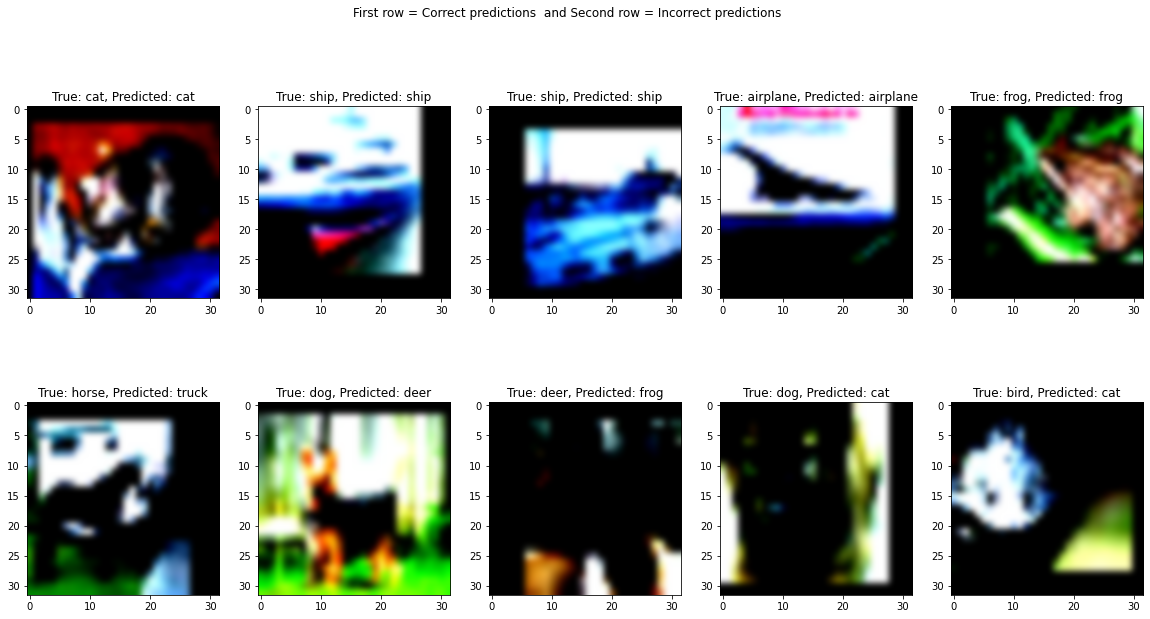

In [4]:
show_loss(Losses, save=True, path=save_dir + '/CIFAR10_Resnet101_Losses.png')
show_accuracy(Accuracy, save=True, path=save_dir + '/CIFAR10_Resnet101_Accuracy.png')
show_result(model, (epoch + 1),show = True, save=True, path=path)